# APPLICATION  D'UNE MCMC pour la SIMULATION A POSTERIORI

Donnees X (debit de riviere) ~ Loi de GUMBEL (mu,lambda)  
A priori sur (mu,lambda) = melange de lois Gamma d'hyperparametres (m, alpha, xe.alpha)  
avec :  
m = taille d'echantillon fictif (force de l'expertise)  
xe_alpha = quantile predictif (sur X, donc positif) a priori de seuil alpha (donne par l'expert)  
alpha    = seuil de xe.alpha, compris dans [0,1]  (donne par l'expert)  
lambda_e = moyenne a priori de lambda (donnee par l'expert)

In [20]:
%matplotlib notebook
from math import floor
from scipy import log, pi, exp, sqrt
from scipy import __version__ as sci_version
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import loggamma
from numpy.random import normal, uniform, gamma
from statistics import mean
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels import __version__ as stm_version
from matplotlib import __version__ as mpl_version
from pandas import __version__ as pd_version
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
print(
      "scipy version " +  sci_version + 
      "\nnumpy version " + np.__version__ +
      "\nmatplotlib version " + mpl_version +
      "\nstatsmodels version " + stm_version +
      "\npandas version " + pd_version
     )

scipy version 1.3.1
numpy version 1.16.0
matplotlib version 3.1.1
statsmodels version 0.11.0
pandas version 0.25.3


## Jeu de donnees 

30 mesures de débit

In [22]:
data = [ 1306, 1235, 1830, 2442, 1128, 3330, 1530, 3192, 2647, 238,  
        706, 1903, 1594,  935, 1100, 2204, 1366, 1629,  522,  642, 1173, 
        424, 1837, 1391, 789,  383, 1858, 917, 1084, 1026]

In [23]:
m = 1
xe_alpha=2000
alpha=0.5
lambda_e=1/2000

##  Algorithme de Metropolis-Hastings-within-Gibbs 

### Densité a priori sur la moyenne

A priori :  
$\lambda \sim Gamma(m, m/\lambda_e)$ en paramètrisation $Gamma(shape, rate)$, $rate = 1/scale $  
$mu \sim Gamma(m, b_m(\lambda))$  en paramètrisation $Gamma(shape, rate)$  
avec $b_m(\lambda) = exp(- \lambda x_{e,\alpha}) / (\alpha^{-1/m} - 1)$

In [24]:
def get_mean_rate_param(l, m, xe_alpha, alpha) :
    """
        Fonction donnant l'hyperparametre d'echelle de la loi a priori de mu
        sachant lambda, m, xe_alpha et alpha
    """
    return exp(- l * xe_alpha) / (alpha ** (- 1 / m) - 1)

def sample_from_prior(n, m, xe_alpha, alpha, lambda_e) :
    """
         Simulation de (mu,lambda) a priori
    """
    l = gamma(shape = m, scale = lambda_e / m, size = n)
    scale_prior = get_mean_rate_param(l, m, xe_alpha, alpha)
    mu = gamma(shape = m, scale = 1 / scale_prior, size = n)
    return {"lambda" : l, "mu" : mu}

### Log-densité a priori sur lambda

In [25]:
def lambda_prior_density(l, lambda_e, m) :
    return m * (log(m) - log(lambda_e)) - loggamma(m) + (m - 1) * log(l) - m * l / lambda_e

### Log-densite a posteriori de lambda 

A posteriori :  
$\pi(\lambda | x_n) = \gamma(\lambda) Gamma(m + n , m/\lambda_e + n\bar{x}_n)$  
avec 
$\bar{x}_n = \frac{1}{n} \sum_{i=1}^n x_i$,  
$\gamma(\lambda) \propto \frac{b^m_m(\lambda)}{(b_m(\lambda) + \bar{b}_{x_n}(\lambda))^{m + n}}$  
et $\bar{b}_{x_n} = \sum_{i = 1}^n exp(-\lambda x_i)$

In [26]:
def compute_informed_parameters(l, uncensored_data = np.array([]), censored_data = np.array([])) :  
    
    x_n = 0
    b_xn = np.zeros(len(l))
    
    if uncensored_data.size > 0 :
        x_n = mean(uncensored_data)
        b_xn = exp(- l[np.newaxis] * (uncensored_data[np.newaxis]).T).sum(axis = 0) + b_xn
    
    if censored_data.size > 0 :
        b_xn = exp(- l[np.newaxis] * (censored_data[np.newaxis]).T).sum(axis = 0) + b_xn
        
    return x_n, b_xn

def lambda_log_posterior(l, m, xe_alpha, alpha, lambda_e, uncensored_data, censored_data) :
    
    # Information apportee par les donnees
    n = len(uncensored_data)
    x_n, b_xn = compute_informed_parameters(l, uncensored_data, censored_data)

    # Information a priori
    b_prior = get_mean_rate_param(l, m, xe_alpha, alpha)
    
    # Statistiques a posteriori
    b_post = b_prior + b_xn
    x_post = n * x_n + m / lambda_e
    
    # expression du log 
    res = (m + n - 1) * log(l) - l * x_post + m * log(b_prior) - (m + n) * log(b_post)
    return(res)

### Simulation conditionnelle de Gibbs de mu sachant lambda a posteriori

In [27]:
def sample_mu_from_posterior(l, m, xe_alpha, alpha, lambda_e,
                           uncensored_data, censored_data) :
    
    # Information apportee par les donnees
    r = uncensored_data.size
    x_n, b_xn = compute_informed_parameters(l, uncensored_data, censored_data)

    # Information a priori
    b_prior = get_mean_rate_param(l, m, xe_alpha, alpha)
  
    # Statistiques a posteriori
    b_post = b_prior + b_xn
    
    return gamma(shape = m + r, scale = 1/b_post, size = len(l))

### Estimateurs du maximum de vraisemblance de la loi de Gumbel

 Estimation rapide des estiamteurs du max de vraisemblance de Gumbel sur des donnees non censurees (via un algorithme de simplexe), utilisés pour initialiser les valeurs de mu et lambda.

In [28]:
def log_density_Gumbel(data, mu, l) :
    return log(l) + log(mu) - l * data - mu * exp(- l* data)

def log_likelihood_Gumbel(uncensored_data, censored_data, mu, l) :
    
    ll = 0
    
    if uncensored_data.size > 0 :   
        ll += np.sum(log_density_Gumbel(uncensored_data, mu, l))

    if censored_data.size > 0 :   
        ll += np.sum(- mu * exp(- l* censored_data))

    return ll


def MLE_Gumbel(data, plotting= True) :
    
    # log-vraisemblance negative a minimiser
    def objective(theta, data) :
        mu = theta[0]
        l = theta[1]
        return - log_likelihood_Gumbel(data, np.array([]), mu ,l)
    
    theta_init = np.array([1, 1])
    optimization = minimize(objective, theta_init, args = data, method = 'Nelder-Mead',
                             options= {"maxiter" : 1000})
    MLE_param = {"mu": optimization.x[0],
                "lambda" : optimization.x[1]} 
    
    if plotting :
        data_range = np.array(range(0, 4000, 40))
        density = exp(log_density_Gumbel(data_range, MLE_param["mu"], MLE_param["lambda"]))
        plt.hist(data, density = True, bins = 10)
        plt.plot(data_range, density)
        plt.xlabel("Donnees de debit")
        plt.ylabel("densite")
        plt.title("Histogramme / Densite de Gumbel estimee")
        
    return MLE_param

### Initialisation de lambda

In [29]:
def initialize_lambda(n_chains, data) :
    MLE = MLE_Gumbel(data, plotting = False)
    return uniform(low = 0, high = 1.5 * MLE["lambda"], size = n_chains)

### Selection de la distribution instrumentale

In [30]:
def make_instrumental_distribution(nb_chains, option, m, xe_alpha, alpha, lambda_e, data) :
    """
        Fonction générant les fonction des log_densite et d'echantillonnage selon l'option selectionnee.
    """
    if option == 1 : 
        
        print("Loi instrumentale choisie : loi a priori\n")
        
        def log_density(x,y) :
            return m * (log(m) - log(lambda_e)) - loggamma(m) + (m - 1) * log(x) - m * x / lambda_e
        
        def sampling(n,x) :
            sample = gamma(shape = m, scale = lambda_e / m, size = (n * nb_chains))
            return np.ndarray(shape =(n,nb_chains), buffer = sample)
    
    
    if option == 2 : 
        
        print("Loi instrumentale choisie : loi gamma semblant proche de l'a posteriori sur lambda\n")
        n = len(data)
        xn = np.mean(data)
        
        def log_density(x,y) :
            return (m + n) * log(m / lambda_e + n * xn) - loggamma(m + n) + (m + n - 1) * log(x) - x * (m / lambda_e + n * xn)
        
        def sampling(n,x) :
            sample = gamma(shape = n + m, scale = 1 / (m / lambda_e + n * xn), size = n * nb_chains)
            return np.ndarray(shape =(n,nb_chains), buffer = sample)

        
    if option == 3 :
        
        print("Loi instrumentale choisie : loi normale de moyenne la valeur courante et de coeff. de variation = 5 %")
        coeff_variation = 0.05
        
        def log_density(x, y) :
            sigma = abs(coeff_variation * y)
            return -0.5 * log(2 * pi) - log(sigma) - (x-y) ** 2 / (2 * (sigma ** 2))
        
        def sampling(n, x) :
            sigma = abs(coeff_variation * x)
            sample = abs(normal(loc = x, scale = sigma, size = n * nb_chains))
            return np.ndarray(shape =(n,nb_chains), buffer = sample)
    
    
    if option == 4 :
        
        print("Loi instrumentale choisie : loi normale de moyenne la valeur courante et de coeff. de variation = 25 %")
        coeff_variation = 0.25
        
        def log_density(x, y) :
            sigma = abs(coeff_variation * y)
            return -0.5 * log(2 * pi) - log(sigma) - (x-y) ** 2 / (2 * (sigma ** 2))
        
        def sampling(n, x) :
            sigma = abs(coeff_variation * x)
            sample = abs(normal(loc = x, scale = sigma, size = n * nb_chains))
            return np.ndarray(shape =(n,nb_chains), buffer = sample)
        
    if option == 5 :
        
        print("Loi instrumentale choisie : loi normale de moyenne la valeur courante et de coeff. de variation = 50 %")
        coeff_variation = 0.5
        
        def log_density(x, y) :
            sigma = abs(coeff_variation * y)
            return -0.5 * log(2 * pi) - log(sigma) - (x-y) ** 2 / (2 * (sigma ** 2))
        
        def sampling(n, x) :
            sigma = abs(coeff_variation * x)
            sample = abs(normal(loc = x, scale = sigma, size = n * nb_chains))
            return np.ndarray(shape =(n,nb_chains), buffer = sample)
        
    return log_density, sampling

### Construction de la fonction de densité a posteriori pour lambda

In [31]:
 def make_log_posterior_density(m, xe_alpha, alpha, lambda_e, uncensored_data, censored_data) :
        
        def log_posterior_density(l) :
            return lambda_log_posterior(l, m, xe_alpha, alpha, lambda_e, uncensored_data, censored_data)
        return log_posterior_density

### Diagnostique de l'échantillonnage

####                 Statistique de Brooks-Gelman

calculee sur un nombre nb_chains de chaines MCMC paralleles pour le parametre theta (matrix Nsim x nb_chains)

In [32]:
def Brooks_Gelman(theta, pro = 0.9) :
    
    (Nsim, nb_chains) = theta.shape
    delta = np.zeros(nb_chains)
    delta = np.quantile(theta[(floor(Nsim/2) - 1):(Nsim - 1)], q = pro, axis = 0) - np.quantile(theta[(floor(Nsim/2) - 1):(Nsim - 1)], q = 1 - pro, axis = 0)
    delta_mean = delta.mean()
    delta = np.quantile(theta[(floor(Nsim/2) - 1):(Nsim - 1)], q = pro) - np.quantile(theta[(floor(Nsim/2) - 1):(Nsim - 1)], q = 1 - pro)
    return delta / delta_mean


### Echantillonnage

In [33]:
def metropolis_hastings_sampling(lambda_old, sampling, log_density, log_posterior_density) :
    
    # simulation instrumentale en parallele 
    sample = sampling(1, lambda_old)
    sample = sample.flatten() # fonctionnera uniquement tant qu'on calcule un échantillon par chaîne
    
    # calcul du logarithme du rapport de Metropolis - Hastings
    density = log_posterior_density(sample) 
    log_ratio = density - log_posterior_density(lambda_old) + log_density(lambda_old, sample) - log_density(sample, lambda_old) 
    
    # calcul du log de la probabilitz moyenne d'acceptation
    log_accept = np.minimum(0, log_ratio)
  
    # mise en oeuvre du test parallelise
    U = uniform(0, 1, lambda_old.size)
    test = np.less_equal(log(U), log_accept)
    
    # acceptation ou conservation des anciens tirages
    refused = sample[~ test]
    sample[np.isnan(sample)] = lambda_old[np.isnan(sample)]
    sample[~ test] = lambda_old[~ test]
    
    return sample, test, exp(density), refused

# calcul du taux d'acceptation effectif en moyenne sur les chaines
def acceptation_rate(test) :
    return test.sum()/test.size

# Calcul de l'autocorrelation  
def autocorrelation(chains_lambda) :  
    lags = range(1,30)
    autocor = pd.DataFrame(np.zeros(len(lags))).T
    autocor.columns = ["Lag" + str(lag) for lag in lags]
    for lag in lags :
        autocor["Lag" + str(lag)] = chains_lambda.apply(lambda col: col.autocorr(lag), axis = 0).median()
    return autocor.to_numpy().flatten().tolist()
  
    
def gibbs_sampling(lambda_sample, m, xe_alpha, alpha, lambda_e,
                           uncensored_data, censored_data) :
    
    # simulation a posteriori conditionnellement a lambda
    sample = sample_mu_from_posterior(lambda_sample, m, xe_alpha, alpha, lambda_e,
                           uncensored_data, censored_data)
    
    return sample

### Graphes

In [34]:
#Lambda distributions
def plot_lambda_distributions(lambda_old, log_density, log_posterior_density, ax) :
    ax.cla()
    values = np.linspace(0, 0.004, 500)
    densities = pd.DataFrame([exp(log_density(value, lambda_old)) for value in values]).set_index(values)
    densities.columns = ["Instrumental " + str(column) for column in densities.columns]
    densities["Prior"] = [exp(lambda_prior_density(value, lambda_e, m)) for value in values]
    densities["Posterior"] =  exp(log_posterior_density(values))
    for column in densities.columns :
        ax.plot(values, densities[column], label = column)
    ax.set_title("Distributions a priori et instrumentales (lambda)")
    ax.set_ylabel("Density")
    ax.set_xlabel("Lambda")
    ax.legend()

# Lambda exploration
def plot_lambda_path(chains_lambda, ax) :
    ax.cla()
    for column in chains_lambda.columns :
        ax.plot(range(1, chains_lambda.shape[0] + 1), chains_lambda[column], label = column)
    ax.set_title("Parcours de MCMC (lambda)")
    ax.set_ylabel("Lambda")
    ax.set_xlabel("Iteration")
    ax.legend()

# Lambda posterior
def plot_lambda_posterior(log_posterior_density, ax) :
    ax.cla()
    values = np.linspace(0, 0.004, 500)
    ax.plot(values, exp(log_posterior_density(values)))
    ax.set_title("Distribution a posteriori (lambda) a un coefficient pres")
    ax.set_ylabel("Density")
    ax.set_xlabel("Lambda")


# Mu prior and posterior
def plot_mu_distributions(lambda_sample, ax, m, xe_alpha, alpha, lambda_e, uncensored_data, censored_data) :
    ax.cla()
    prior = sample_from_prior(50000, m, xe_alpha, alpha, lambda_e)
    prior_hist, prior_edges = np.histogram(prior["mu"], bins = 100, density = True)
    posterior = sample_mu_from_posterior(np.array(lambda_sample.tolist() * 5000), m, xe_alpha, alpha, lambda_e, uncensored_data, censored_data)
    posterior_hist, posterior_edges = np.histogram(posterior, bins = 100, density = True)
    ax.plot(prior_edges[:-1], prior_hist, label = "Prior")
    ax.plot([(a + b) / 2 for a, b in zip(posterior_edges[:-1], posterior_edges[1:])], posterior_hist, label = "Posterior")
    ax.legend()
    ax.set_xlim(0, 30)
    ax.set_title("Mu distributions")
    ax.set_xlabel("Log(Mu)")
    ax.set_ylabel("Density")

# Mu exploration
def plot_mu_path(chains_mu, ax) :
    ax.cla()
    for column in chains_mu.columns :
        ax.plot(range(1, chains_mu.shape[0] + 1), chains_mu[column], label = column)
    ax.set_title("Parcours de MCMC (mu)")
    ax.set_ylabel("Mu")
    ax.set_xlabel("Iteration")
    ax.legend()

# Parcours 2D
def plot_2D_path(lambda_acc, mu_acc, lambda_refused, mu_refused, lambda_chain, mu_chain, ax) :
    ax.cla()
    ax.scatter(lambda_acc, mu_acc, marker = "o", color = "blue", label = "accepted")
    ax.scatter(lambda_refused, mu_refused, marker = "h", color = "red", label = "refused")
    ax.legend()
    ax.set_ylabel("Mu")
    ax.set_xlabel("Lambda")
    if len(lambda_acc)  < 50 :
        ax.plot(lambda_acc, mu_acc)
    else :
        ax.plot(lambda_acc[:50], mu_acc[:50])
    if len(lambda_chain) > 20 :
        hist, xedges, yedges = np.histogram2d(lambda_chain, mu_chain, bins=min(len(lambda_chain) // 5, 10))
        x_coord = [(a + b) / 2 for a, b in zip(xedges[:-1], xedges[1:])]
        y_coord = [(a + b) / 2 for a, b in zip(yedges[:-1], yedges[1:])]
        ax.contour(hist, extent=[min(x_coord),max(x_coord),min(y_coord),max(y_coord)],
                   levels = min((len(xedges) - 1 ) // 3, 6))
    ax.set_title("Parcours de la chaine 0")
    y = deepcopy(lambda_acc)
    y.extend(lambda_refused)
    ax.set_xlim(min(y) - 0.0002,
                max(y) + 0.0002)
    ax.legend()
    

# Taux d'acceptation
def plot_acceptation(k, acc_rate, ax) :
    ax.cla()
    ax.plot(range(1, k + 1), np.cumsum(acc_rate)/range(1, k + 1))
    ax.set_title("Evolution du taux d'acceptation")
    ax.set_ylabel("Taux d'acceptation")
    ax.set_xlabel("Iteration")

#GB stat
def plot_GB(GB_stat, ax) :
    ax.cla()
    ax.plot(range(49, 49 + len(GB_stat)), GB_stat)
    ax.set_title("Evolution de la statistique de Brooks-Gelman")
    ax.set_ylabel("R")
    ax.set_xlabel("Iteration")
    ax.axhline(y = 1, linestyle = "--", color = "gray")

# Autocorrelation
def plot_autocorrelation(autocor, ax) :
    ax.cla()
    ax.plot(range(1, len(autocor) + 1), autocor)
    ax.set_title("Autocorrelation des chaînes lambda")
    ax.set_ylabel("Autocorrelation")
    ax.set_xlabel("Lag")
    ax.axhline(y = 0, linestyle = "--", color = "gray")

### Boucle MCMC complète

In [35]:
def metropolis_hastings_within_gibbs(data, option = 1, N = 1000, burn_in = 5000, nb_chains = 3,
                                     m = 1, xe_alpha = 2000, alpha = 0.5, lambda_e = 1/2000, 
                                     pause = range(1,101), plotting= range(1, 10)) :
    
    
    
    log_density, sampling = make_instrumental_distribution(nb_chains, option, m, 
                                                           xe_alpha, alpha, lambda_e, data)
    
    log_posterior_density = make_log_posterior_density(m, xe_alpha, alpha, lambda_e, np.array(data), np.array([]))
    
    # initialisation au hasard entre 0 et 1.5*lambda(MLE)
    lambda_old = initialize_lambda(nb_chains, np.array(data))
    chains_lambda = pd.DataFrame(lambda_old).T
    chains_mu = sample_mu_from_posterior(lambda_old, m, xe_alpha, 
                                         alpha, lambda_e, np.array(data), np.array([]))
    chains_mu = pd.DataFrame(chains_mu).T
    
    # Initialisation des variables de suivi et des plots
    GB_stat = []
    acc_rate = []
    lambda_refused = []
    mu_refused = []
    lambda_acc = []
    mu_acc = []
    
    fig, ([ax1, ax2, ax3],
         [ax4, ax5, ax6],
         [ax7, ax8, ax9]) = plt.subplots(3,3)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
  #----------------------------------------------------------------#
  #               BOUCLE MCMC                                      # 
  #----------------------------------------------------------------#
    for k in range(1, burn_in + N + 1) :
        
        lambda_sample, test, density, refused = metropolis_hastings_sampling(lambda_old, sampling, log_density, log_posterior_density)
        acc_rate.append(acceptation_rate(test))
        mu_sample = sample_mu_from_posterior(lambda_sample, m, xe_alpha, alpha, lambda_e,
                           np.array(data), np.array([]))
        
        chains_lambda = chains_lambda.append(pd.DataFrame(lambda_sample).T).reset_index(drop = True)
        chains_mu = chains_mu.append(pd.DataFrame(mu_sample).T).reset_index(drop = True)
        
        # conservation des tirages successifs (chaine 1) acceptes ou refuses
        if not test[0] :
            lambda_refused.append(refused[0])
            mu_refused.append(sample_mu_from_posterior(lambda_sample, m, xe_alpha, alpha, lambda_e,
                          np.array(data), np.array([]))[0])
        else :
            lambda_acc.append(lambda_sample[0])
            mu_acc.append(mu_sample[0])
    
        # Calcul de l'autocorrelation à partir de 30 itérations
        if k > 29 :
            autocor = autocorrelation(chains_lambda)
        
        # Calcul statistique Brooks-Gelman jointe sur (lambda, beta) a partir de 50 iterations
        if k > 49 :
            GB_stat.append(Brooks_Gelman(chains_lambda))
         
        # Plotting 
        if 1 in plotting :
            plot_lambda_distributions(lambda_old, log_density, 
                                      log_posterior_density, ax1)
        
        if 2 in plotting :
            plot_lambda_path(chains_lambda, ax2)
        
        if 3 in plotting :
            plot_lambda_posterior(log_posterior_density, ax3)
            
        if 4 in plotting :
            plot_mu_distributions(lambda_sample, ax4, m, xe_alpha, alpha,
                                  lambda_e, np.array(data), np.array([]))
            
        if 5 in plotting :
            plot_mu_path(chains_mu, ax5)
        
        if 6 in plotting :
            plot_2D_path(lambda_acc, mu_acc, lambda_refused, 
                         mu_refused, chains_lambda[[0]].to_numpy().flatten().tolist(), 
                         chains_mu[[0]].to_numpy().flatten().tolist(), ax6)
        
        if 7 in plotting :
            plot_acceptation(k, acc_rate, ax7)
        
        if 8 in plotting and len(GB_stat) > 0:
            plot_GB(GB_stat, ax8)
            
        if 9 in plotting and k > 29 :
            plot_autocorrelation(autocor, ax9)
        
        fig.canvas.draw()
        
        # Remise a jour du tirage courant
        lambda_old = lambda_sample
        

    return chains_lambda, chains_mu


Loi instrumentale choisie : loi normale de moyenne la valeur courante et de coeff. de variation = 25 %


<IPython.core.display.Javascript object>


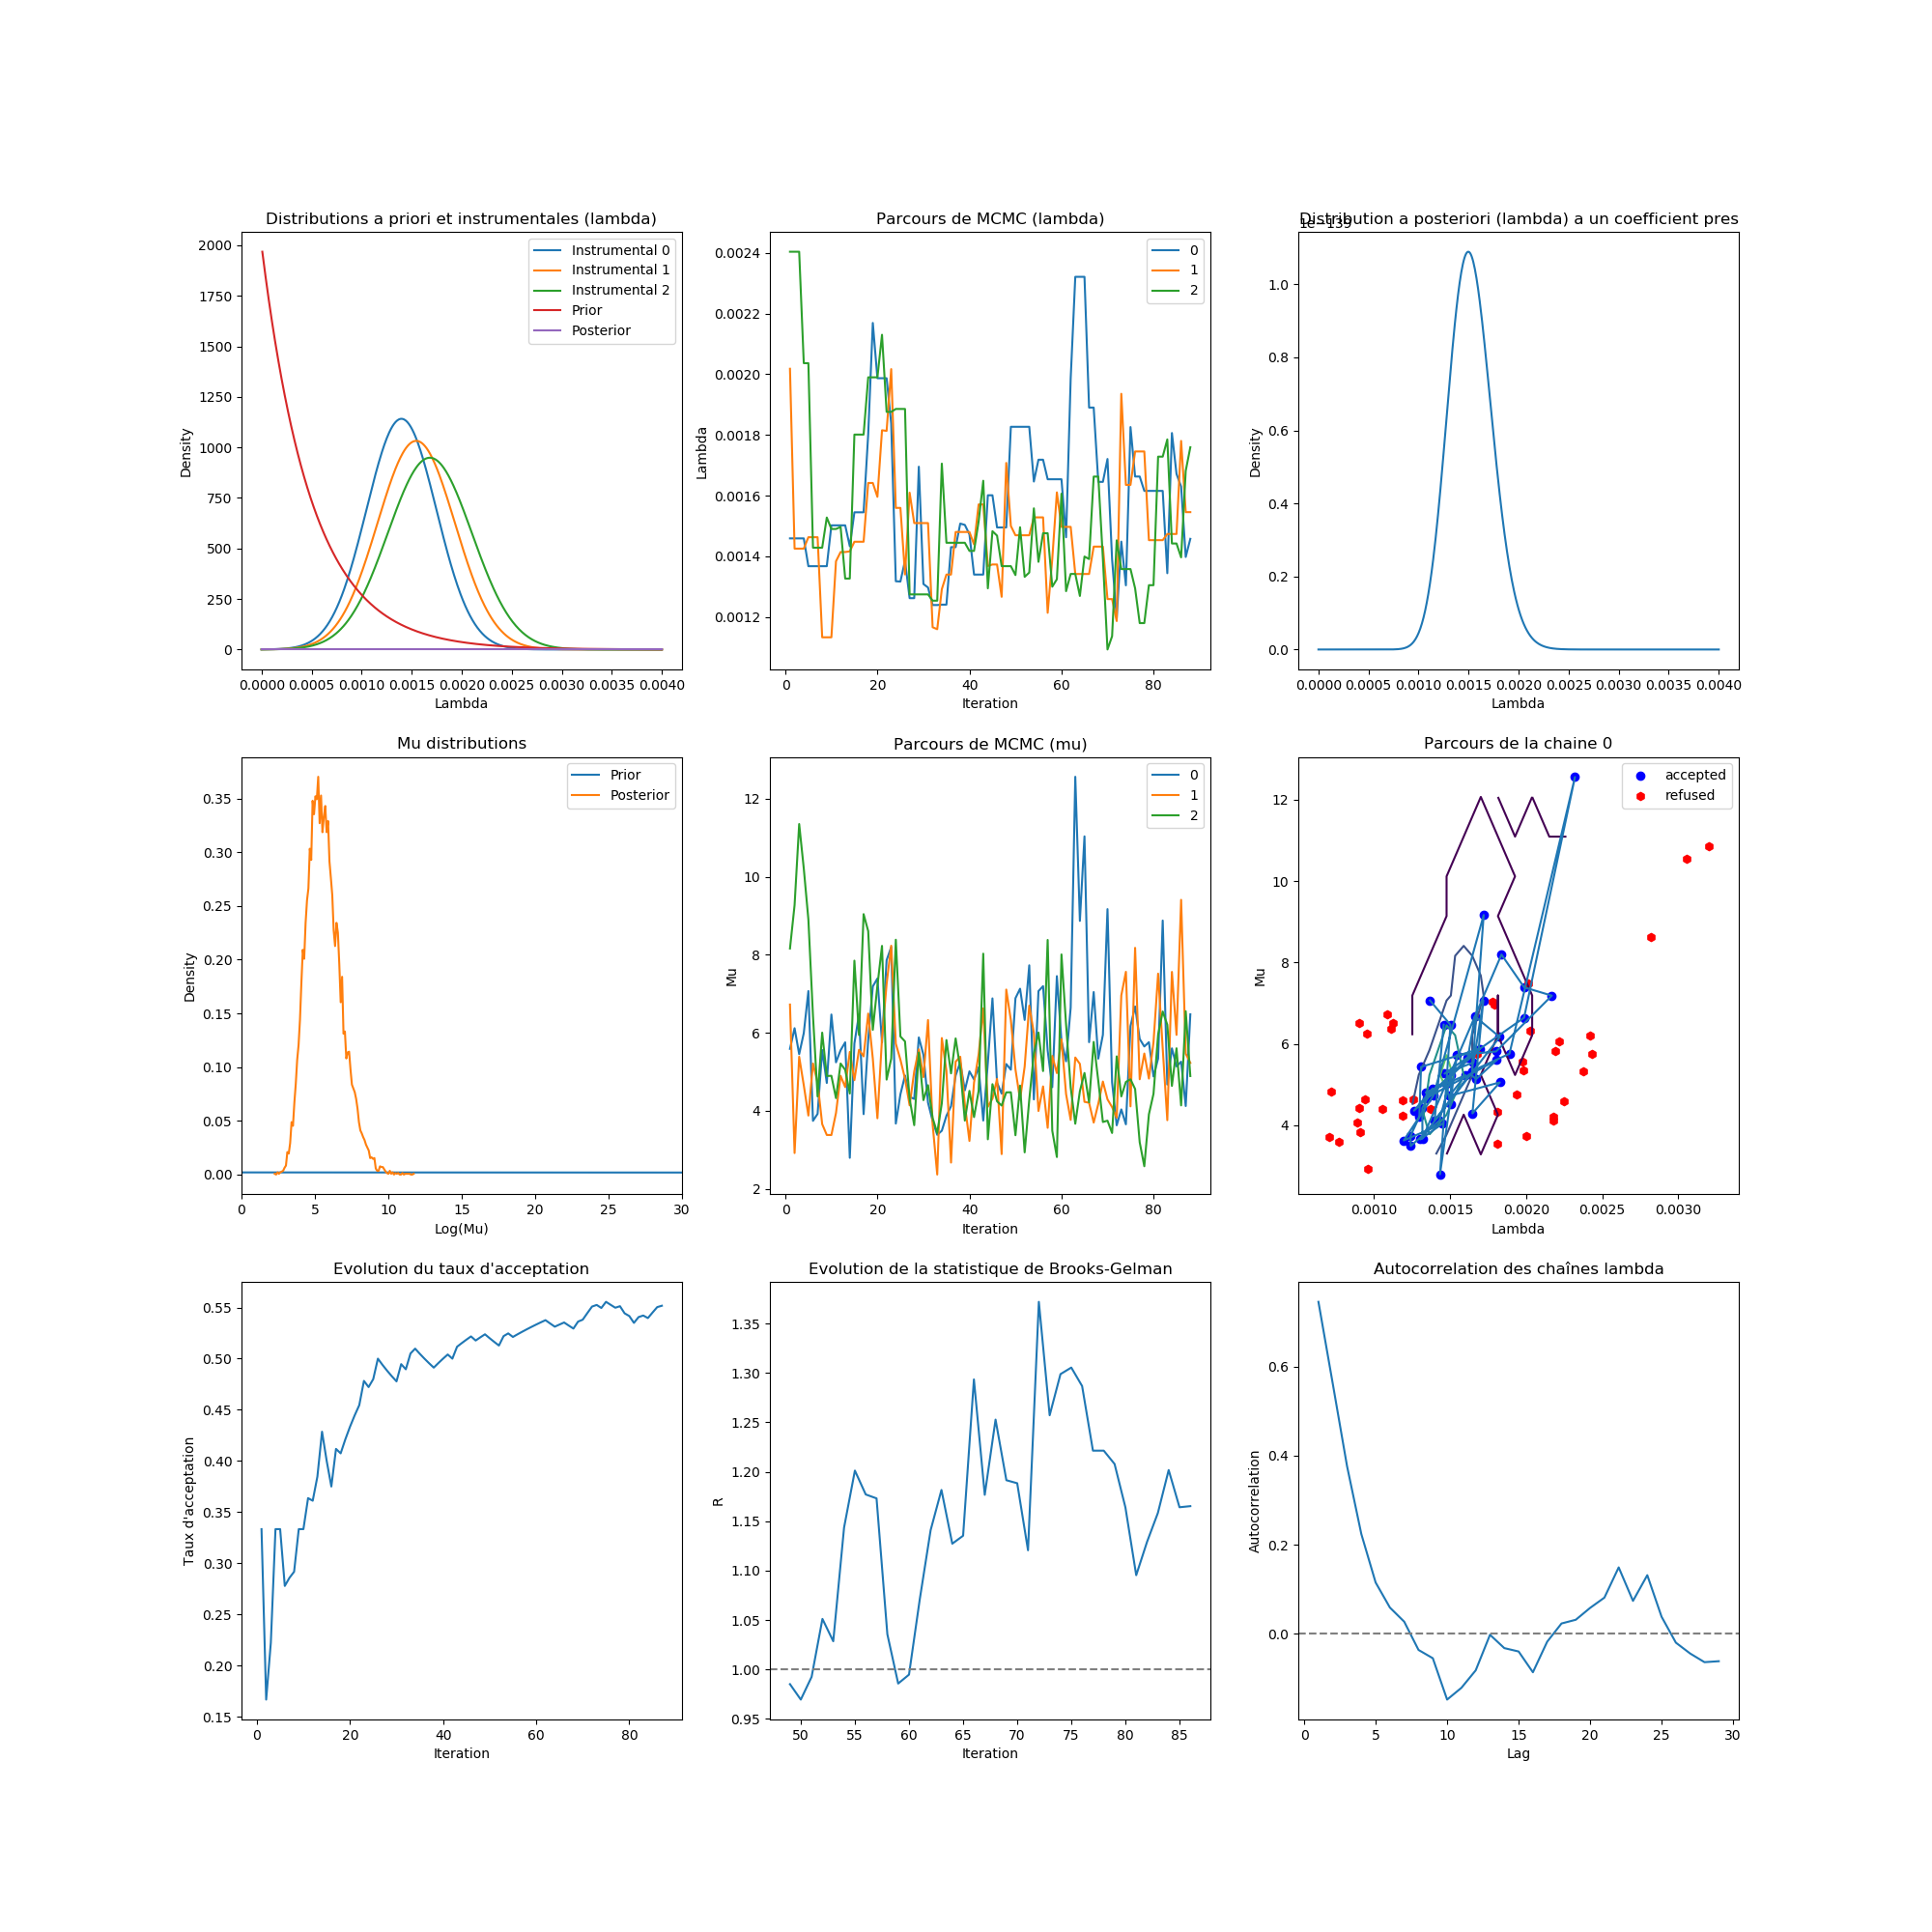

/Users/nicolasbousquet/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/scimath.py:274: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
/Users/nicolasbousquet/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nicolasbousquet/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
lambdas, mu =  metropolis_hastings_within_gibbs(data, option = 4, nb_chains = 3)